In [2]:
# TODO: Data Loader module see 
# https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

%load_ext autoreload
%autoreload 2

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import librosa
import mido
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
BUNDLE_SEPARATOR = 128
EOS = 129

In [5]:
# Bundle all note events together based on their time offset from each other
# Returns an array with dimensions (tracks, bundles per track)
def bundle_events(midi_file : mido.MidiFile):
    track_bundles = []

    for i, track in enumerate(midi_file.tracks):
        bundle = []
        bundles = []
        for msg in track:
            attrs = msg.dict()
            type = attrs["type"]

            if type == 'note_on' or type == 'note_off':
                if attrs['time'] == 0 or len(bundle) == 0:
                    bundle.append(attrs)
                else:
                    # Ensure that the first entry in the list has the time stamp info
                    delta = bundle[0]['time']
                    # Sort each entry in each bundle based on the note (in ascending order) 
                    sorted_bundle = sorted(bundle, key=lambda x: int(x['note']))

                    # Set all bundle entries to have time = 0 except for the first entry
                    for b in sorted_bundle:
                        b['time'] = 0
                    sorted_bundle[0]['time'] = delta 

                    bundles.append(sorted_bundle)

                    bundle.clear()
                    bundle.append(attrs)

        track_bundles.append(bundles)

    return track_bundles

In [6]:
# Augment track bundles by removing note off / velocity = 0 events. 
def augment_track_bundles(track_bundles):
    augmented_track_bundles = []

    # entries are of the form
    # note_id : {event, time_started, idx }
    state = {}

    for track in track_bundles:
        aug = [[] for i in range(0, len(track))]
        time = 0

        for i, bundle in enumerate(track): 
            time += bundle[0]['time']
            for event in bundle: 
                if event['type'] == 'note_off' or event['velocity'] == 0:
                    info = state[event['note']]
                    info['event']['duration'] = time - info['time']
                    info['event']['time'] = info['time']

                    if 'type' in info['event'].keys():
                        del info['event']['type']

                    aug[info['idx']].append(info['event']) 
                else: 
                    state[event['note']] = {'event': event, 'time': time, 'idx': i}

        # Remove any empty entries
        augmented_track_bundles.append(filter(lambda x : len(x) != 0, aug))

    return augmented_track_bundles

In [7]:
# Convert bundles to a list of notes, durations and velocities. 
# Each bundle note and velocity is separated from each other.
# Each duration corresponds to the duration of the ntote
# Each time corresponds to how far apart things are spaced. 
# Each velocity is normalized to be between 0 and 1 (by dividing by 127)

def create_lists(track_bundles):    
    track_notes = []
    track_durations = []
    track_times = []
    track_velocities = []

    for track in track_bundles:
        notes = []
        durations = []
        times = []
        velocities = []
        
        current_time = 0

        for b in track:
            time = b[0]['time'] - current_time
            for x in b: 
                notes.append(x['note'])
                durations.append(x['duration'])
                velocities.append(int(x['velocity']))

            notes.append(BUNDLE_SEPARATOR)
            durations.append(0)
            times.append(time)
            velocities.append(0)

            current_time = time

        notes.append(EOS)
        durations.append(0)
        times.append(0)
        velocities.append(0)

        track_notes.append(notes)
        track_durations.append(durations)
        track_times.append(times)
        track_velocities.append(velocities)

    return np.array(track_notes), \
        np.array(track_durations), \
        np.array(track_times), \
        np.array(track_velocities)

In [8]:
def normalize_to_beats(track_arr, ticks_per_beat):
    return track_arr / ticks_per_beat

In [9]:
def process_midi(path, logs = False):
    midi_file = mido.MidiFile(path)

    if logs:
        print(path)
        print("Samples: ", len(midi_file.tracks[0]))

    track_bundles = bundle_events(midi_file)
    augmented_bundles = augment_track_bundles(track_bundles)
    track_notes, track_durations, track_times, track_velocities = create_lists(augmented_bundles)

    track_durations = normalize_to_beats(track_durations, midi_file.ticks_per_beat)
    track_times = normalize_to_beats(track_times, midi_file.ticks_per_beat)
    
    return track_notes[0], track_durations[0], track_times[0], track_velocities[0]

# Dataset Creation

In [10]:
def make_dataset(midis) -> pd.DataFrame:

    df = pd.DataFrame(columns=["notes", "durations", "times", "velocities"])

    for mid in midis:
        n, d, t, v = process_midi(mid)
        df.loc[len(df.index)] = [n, d, t, v]

    return df

In [11]:
class MidiDataset(Dataset):
    def __init__(self, notes, durations, times, velocities):
        self.notes = notes 
        self.durations = durations 
        self.times = times
        self.velocities = velocities
    
    def __len__(self):
        return len(self.notes)
    
    def __getitem__(self, idx):
        notes = self.notes[idx]
        durations = self.durations[idx]
        times = self.times[idx]
        velocities = self.velocities[idx]

        sample = {"notes": notes, "durations": durations, "times": times, "velocities": velocities }
        return sample

In [12]:
MIDI_PATH = r"data/Ludwig van Beethoven/Ode to Joy from the 9th Symphony.mid"
df = make_dataset([MIDI_PATH])

In [13]:
midi = MidiDataset(df['notes'], df['durations'], df['times'], df['velocities'])

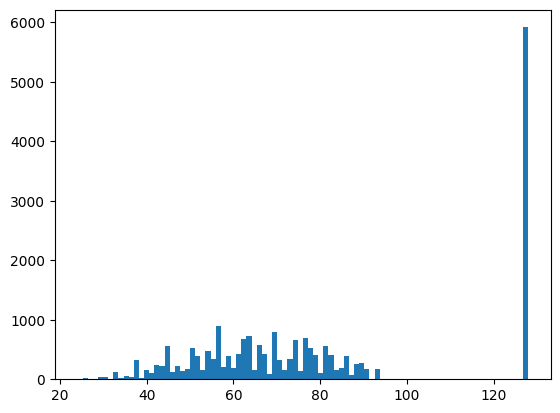

In [14]:
plt.hist([x for x in filter(lambda x : x > 0, df['notes'][0][:-2])], bins=88)
plt.show()

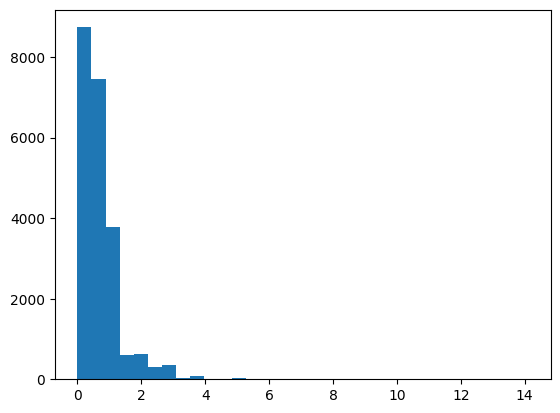

[0.00000000e+00 4.16666667e-03 8.33333333e-03 1.25000000e-02
 1.66666667e-02 2.08333333e-02 2.50000000e-02 2.91666667e-02
 3.33333333e-02 3.75000000e-02 4.16666667e-02 4.58333333e-02
 5.00000000e-02 5.41666667e-02 5.83333333e-02 6.25000000e-02
 6.66666667e-02 7.08333333e-02 7.50000000e-02 7.91666667e-02
 8.33333333e-02 8.75000000e-02 9.16666667e-02 9.58333333e-02
 1.00000000e-01 1.04166667e-01 1.08333333e-01 1.12500000e-01
 1.16666667e-01 1.20833333e-01 1.25000000e-01 1.29166667e-01
 1.33333333e-01 1.37500000e-01 1.41666667e-01 1.45833333e-01
 1.50000000e-01 1.54166667e-01 1.58333333e-01 1.62500000e-01
 1.66666667e-01 1.70833333e-01 1.75000000e-01 1.79166667e-01
 1.83333333e-01 1.87500000e-01 1.91666667e-01 1.95833333e-01
 2.00000000e-01 2.04166667e-01 2.08333333e-01 2.12500000e-01
 2.16666667e-01 2.20833333e-01 2.25000000e-01 2.29166667e-01
 2.33333333e-01 2.37500000e-01 2.41666667e-01 2.45833333e-01
 2.50000000e-01 2.54166667e-01 2.58333333e-01 2.62500000e-01
 2.66666667e-01 2.708333

In [21]:
plt.hist(df['durations'][0], bins=32)
plt.show()

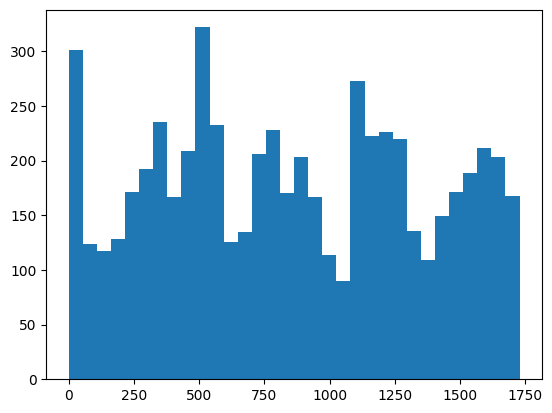

In [16]:
plt.hist(df['times'][0], bins=32)
plt.show()




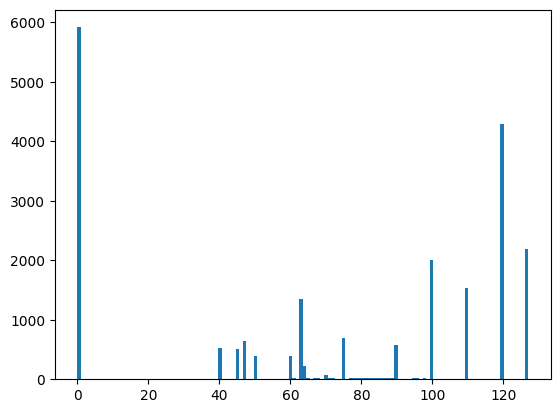

In [17]:
plt.hist(df['velocities'][0], bins=128)
plt.show()

In [18]:
train_loader = DataLoader(midi, batch_size=1)

# Model

In [73]:
from model import ComposeNet, VOCABULARY
model = ComposeNet()

data = next(iter(train_loader))
note_tensor = data['notes'][:, :model._context_len]
note_tensor = note_tensor.to("cuda")

velocity_tensor = data['velocities'][:, :model._context_len ]
velocity_tensor = velocity_tensor.to("cuda")

duration_tensor = data['durations'][:, :model._context_len ]
duration_tensor = duration_tensor.to("cuda")

input = {
    "notes": note_tensor,
    "velocities": velocity_tensor,
    "durations": duration_tensor 
}

print("Input Tensor = ", note_tensor.shape, velocity_tensor.shape, duration_tensor.shape)

output_notes, output_velocities, output_durations = model(input)

output_notes = output_notes.cpu().detach().numpy()
output_velocities = output_velocities.cpu().detach().numpy()
output_durations = output_durations.cpu().detach().numpy()

print("Output Tensor = ", output_notes.shape, output_velocities.shape, output_durations.shape)

print("Note = ", librosa.midi_to_note(output_notes[0].argmax()))
print("Velocity = ", output_velocities[0].argmax())
print("Duration = ", output_durations[0].argmax())


Input Tensor =  torch.Size([1, 1024]) torch.Size([1, 1024]) torch.Size([1, 1024])
Output Tensor =  (1, 131) (1, 128) (1, 1024, 1)
Note =  G-1
Velocity =  115
Duration =  799


In [20]:
# Model Specifications
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.119MB


In [ ]:
plt.bar(np.linspace(0, len(VOCABULARY), len(VOCABULARY)), output_notes.reshape((-1,)))
plt.show()